<br>

* [참고커널: PetFinder.my - Optuna + LightGBM on Meta Features](https://www.kaggle.com/kaushal2896/petfinder-my-optuna-lightgbm-on-meta-features#Regression-using-Light-GBM)


* [추가학습: META-Features-XGBoost-LightGBM-CatBoost-OPTUNA](https://www.kaggle.com/oguzhansahin/meta-features-xgboost-lightgbm-catboost-optuna/notebook)

<br>

<br>

## 주요 포인트

* **연속형 타겟변수의 분포가 bimodal 및 multimodal 경우의 데이터 분할 방법**


* **functools 사용하여 파생함수 연동 가능**


* **np.vstack, np.hstack 및 reshape를 이용한 데이터 재배열 연습**


* **optuna 이용, 하이퍼 파라미터 튜닝**

<br>

In [1]:
from functools import partial

import numpy as np
import pandas as pd

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
import seaborn as sns

import warnings

import optuna
from tqdm import tqdm

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn') 
sns.set(font_scale=1)  
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

print("Let's start!")

Let's start!


In [2]:
trn = pd.read_csv("./petfinder-pawpularity-score/train.csv")

display(trn.shape, trn.head())

(9912, 14)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


<br>

## Target distribution

<br>

본 커널은 OOF(Out Of Folds)방식을 이용하여 모델 구축 및 예측을 수행한 것이 특징이다.


[OOF 참고-1](https://techblog-history-younghunjo1.tistory.com/142)


[OOF 참고-2](https://ekdud7667.tistory.com/entry/Ensemble-%EA%B0%9C%EC%9A%94Bagging-Boosting-Stacking)


따라서 각 Folds들의 분포가 서로 비슷해야 일관성 있는 base 모델들을 만들어 낼 수 있다.

우선, 커널 작성자는 타겟변수인 Pawpularity가 아래와 같이 bimodal분포를 나타낸다 라고 판단하고 있다.

이 경우 단순히 kfold로 수행하게 되면 개별 fold 간의 분포가 차이가 생기는 문제가 발생할 수 있다.

<br>

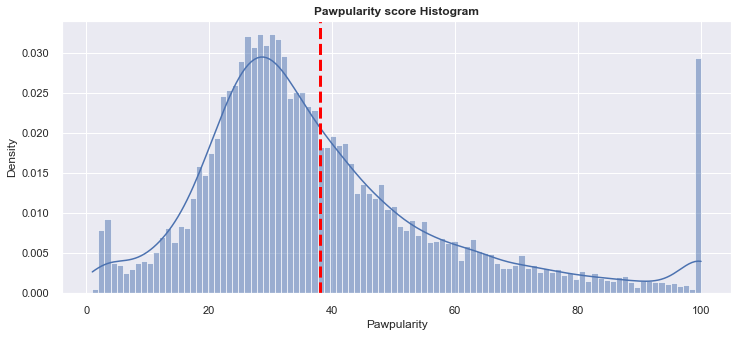

In [3]:
# histogram for Pawpularity score

plt.figure(figsize=(12,5))
sns.histplot(data = trn, x = 'Pawpularity',kde = True, stat = 'density', bins = 100)
plt.axvline(trn['Pawpularity'].mean(),c = 'red', ls = '--', lw = 3)
plt.title('Pawpularity score Histogram', fontsize = 12, fontweight = 'bold')
plt.show()

<br><br>

## Stratified split from the continuous target variable

* **타겟변수가 연속형 변수일 때의 계층적 데이터 추출 및 분할**
    * 타겟변수의 값에 따라 여러 층으로 데이터를 분할 후 각 층별로 랜덤데이터를 추출하여 원래 데이터의 분포와 유사하게 추출
    * 원래 classification 문제에서 train_test_split 시 stratify 옵션을 이용하여 수행
    * 연속형 타겟변수의 분포가 불균형한 bimodal, 또는 multimodal 분포라면 단순 분할 시 추출이 불균형하게 이루어질 수 있다.
    
    
* **방법**
    * pd.cut을 통해 binning
    * 이 bin들을 각 층으로 인식하고, 각 층에서 거의 동일한 비율로 랜덤데이터를 추출하게 함.
    
**[아이디어 참고 커널](https://www.kaggle.com/tolgadincer/continuous-target-stratification)**

<br>

In [4]:
trn["kfold"] = -1    # kfold 컬럼을 만들어 아무 숫자나 할당한다.

N_FOLDS = 5       # fold의 n은 5로 설정
skf = StratifiedKFold(n_splits=N_FOLDS)    # skf 생성

trn["groups"] = pd.cut(trn["Pawpularity"], bins=10, labels=False)   # groups 컬럼을 만들어 0 ~ 9까지 10개의 bins가 할당
target = trn["groups"]  # bin값이 범주가 되도록 target 으로 만들기. 향후 이를 기준으로 split할 것임.


# enumerate을 통해 fold값을 출력하게 되는데, 이 값을 다섯 세트의 val_idx의 "kfold"컬럼에 할당한다.
# 즉, stratify를 통해 모든 fold의 validation set은 전부 다르다는 점을 이용해서 0부터 4까지를 할당하는 것이다.
# 이런 식으로 "kfold"컬럼에 전부 값이 할당되고 나면 "groups"컬럼은 더 이상 필요없으니 삭제한다.

for fold, (trn_idx, val_idx) in enumerate(skf.split(target, target)):
    trn.loc[val_idx, 'kfold'] = fold
    
    label_trn = target.iloc[trn_idx]
    label_val = target.iloc[val_idx]
    print(f'교차검증: {fold}')
    print(f'학습 레이블 데이터 분포: \n', label_trn.value_counts(normalize = True))
    print(f'검증 레이블 데이터 분포: \n', label_val.value_counts(normalize = True))
    print('\n')
    
trn.drop(["groups"], axis=1, inplace = True)
trn.head()

교차검증: 0
학습 레이블 데이터 분포: 
 2    0.280363
3    0.236095
4    0.137596
1    0.102031
5    0.073149
6    0.044520
0    0.040863
9    0.039223
7    0.028755
8    0.017404
Name: groups, dtype: float64
검증 레이블 데이터 분포: 
 2    0.280383
3    0.236006
4    0.137166
1    0.102370
5    0.073122
6    0.044881
0    0.040847
9    0.038830
7    0.028744
8    0.017650
Name: groups, dtype: float64


교차검증: 1
학습 레이블 데이터 분포: 
 2    0.280363
3    0.236095
4    0.137596
1    0.102157
5    0.073149
6    0.044520
0    0.040863
9    0.039097
7    0.028755
8    0.017404
Name: groups, dtype: float64
검증 레이블 데이터 분포: 
 2    0.280383
3    0.236006
4    0.137166
1    0.101866
5    0.073122
6    0.044881
0    0.040847
9    0.039334
7    0.028744
8    0.017650
Name: groups, dtype: float64


교차검증: 2
학습 레이블 데이터 분포: 
 2    0.280328
3    0.236066
4    0.137453
1    0.102144
5    0.073140
6    0.044641
0    0.040858
9    0.039092
7    0.028752
8    0.017528
Name: groups, dtype: float64
검증 레이블 데이터 분포: 
 2    0.280525
3    0.2361

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,kfold
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,0
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,0
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,0
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,0
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,0


<br><br>

## Distribution of each split

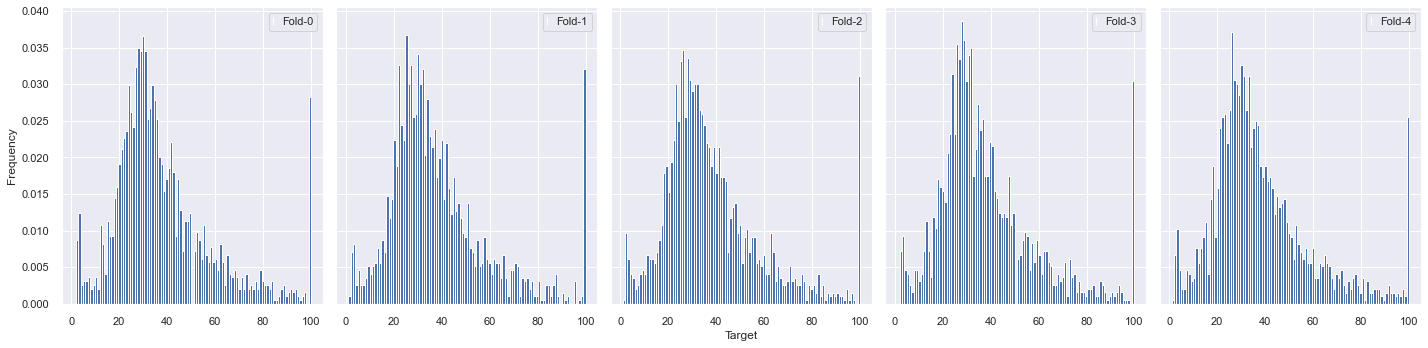

In [5]:
# 진짜 extreme bimodal, multimodal인 경우는 사용해볼만 하다고 생각된다.

fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.hist(trn[trn["kfold"] == i]["Pawpularity"], bins=100, density=True, label=f"Fold-{i}")
    if i == 0:
        ax.set_ylabel("Frequency")
    if i == 2:
        ax.set_xlabel("Target")
    ax.legend(frameon = True, handlelength = 0)
    
plt.tight_layout()
plt.show()

<br><br>

## Regression using Light GBM

In [6]:
trn.head(3)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,kfold
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,0
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,0
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,0


In [7]:
# feature, target 구분
features = trn.columns[1:-2]
target = ["Pawpularity"]

<br>

### [잠깐] np.hstack과 np.vstack, 그리고 reshape를 이용한 데이터 재배열 연습

In [1]:
# 연습

a = np.arange(1, 6)
b = np.arange(1, 4)

print(a.shape, b.shape)
print('\n')
print(np.hstack((a, b)))

(5,) (3,)


[1 2 3 4 5 1 2 3]


In [6]:
# 연습

c = np.array([[1], [2], [3], [4], [5]])
d = np.array([[1], [2], [3], [4], [5]])

print(c.shape, d.shape)
print('\n')
print(np.vstack((c, d)))
print('\n')
print(np.vstack((c, d)).reshape(-1))

(5, 1) (5, 1)


[[1]
 [2]
 [3]
 [4]
 [5]
 [1]
 [2]
 [3]
 [4]
 [5]]


[1 2 3 4 5 1 2 3 4 5]


In [11]:
c.ravel()

array([1, 2, 3, 4, 5])

<br>

이러한 성질을 이용하여 아래와 같이 oof_score 점수를 계산하는 함수 구현

<br>

<br>

### optuna 를 이용한 하이퍼 파라미터 튜닝

<br>

[베이지안 최적화 설명 참고](https://wooono.tistory.com/102)

[optuna for LGBM 참고 커널](https://www.kaggle.com/bextuychiev/lgbm-optuna-hyperparameter-tuning-w-understanding/notebook)

[위 커널 작성자의 Optuna 관련 article](https://towardsdatascience.com/why-is-everyone-at-kaggle-obsessed-with-optuna-for-hyperparameter-tuning-7608fdca337c)

#### step1. Creating the search grid in Optuna

* 탐색할 파라미터의 범위를 딕셔너리 형태로 만듦

* 하이퍼 파라미터 조합 set을 적용할 모델 생성

* 모델 피팅 및 예측 수행

* 지정된 metric에 따른 모델 성능 평가 점수 반환

In [10]:
# out of folds 점수 계산 함수 구현: 

def oof_score(models, trn):
    
    preds, targets = [], []
    
    for idx, model in enumerate(models):
        preds.append(model.predict(trn[trn["kfold"] == idx][features]))
        targets.append(trn[trn["kfold"] == idx][target].values)
    preds, targets = np.hstack(preds), np.vstack(targets).reshape(-1)
    return mean_squared_error(targets, preds, squared = False)  # squared = False 로 설정하면 굳이 np.sqrt 안해도 RMSE로 반환한다.

In [11]:
def objective(trial, trn, features, target):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'rmse'},
        'n_estimators': trial.suggest_int("n_estimators", 64, 8192),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 0.25, log=True),
        'num_leaves': trial.suggest_int("num_leaves", 8, 4096),
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'feature_fraction': trial.suggest_float("feature_fraction", 0.1, 1.0),
        'lambda_l1': trial.suggest_loguniform("lambda_l1", 1e-8, 100.0),
        'lambda_l2': trial.suggest_loguniform("lambda_l2", 1e-8, 100.0),
        'seed': 42,
        'deterministic': True,
        'verbose':-1
    }

    models = []
    for fold in range(N_FOLDS):
        train = trn[trn["kfold"] != fold]
        val = trn[trn["kfold"] == fold]

        x_train, y_train = train[features], train[target]
        x_val, y_val = val[features], val[target]

        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_val = lgb.Dataset(x_val, y_val)

        model = lgb.train(
            params,
            lgb_train,
            num_boost_round=5000,
            valid_sets=(lgb_train, lgb_val),
            early_stopping_rounds=100,
            verbose_eval=False        
        )
        models.append(model)
    return oof_score(models, trn)

<br><br><br>

#### [잠깐] functools의 partial 사용해보기

[참고](https://hamait.tistory.com/823)

In [12]:
# 단순히 제곱 계산 식
def power(base, exponent):
    return base ** exponent


In [13]:
# 정해진 지수를 갖는 전용 함수를 만드려면 아래와 같이 수행
# 그러나 이런 식으로 만들어야 할 함수가 너무 많아진다면 비효율적인 작업이 될 것.

def square(base):
    return power(base, 2)

def cube(base):
    return power(base, 3)

In [14]:
# 따라서 아래와 같이 partial을 이용하여 간소화할 수 있다.

square_new = partial(power, exponent=2)
cube_new = partial(power, exponent=3)

In [15]:
square_new(2)

4

<br>

위 partial 연습한 부분을 응용하여 아래와 같이 opt_fun을 만들겠다.

<br>

<br><br>

#### step2. Creating Optuna study and running trials

* optuna.create_study를 통해 study 객체 생성

* 생성된 study 객체에 optimize 명령. optimize의 인자는 위에서 생성한 objective function이 된다. 여기서 trial 횟수도 지정해야 한다.

* 이후 study 객체를 이용하여 best_params, best_value 등 결과를 확인할 수 있다.

In [16]:
# 여기서 partial을 활용한 것이 확실히 효율적인 지는 모르겠지만,
# 위에서 objective함수를 구현하면서 필요한 인자를 partial을 이용해 opt_fun에 한 번에 담았고 
# study.optimize 명령에서 이를 이용하였다는 것을 알 수 있다.

opt_fun = partial(
    objective,
    trn = trn,
    features = features,
    target = target
)

# opt_fun = lambda trial : objective(trial, trn, features, target) 
# 이렇게 해도 결과는 같음

study = optuna.create_study(direction="minimize")
study.optimize(opt_fun, n_trials=10)
print(study.best_params)

[I 2021-10-15 16:48:53,949] A new study created in memory with name: no-name-27955db3-2cb8-4bcd-a5ca-5d709569190f
[I 2021-10-15 16:48:55,577] Trial 0 finished with value: 20.573240169082755 and parameters: {'n_estimators': 6525, 'learning_rate': 0.0021207127179133927, 'num_leaves': 2884, 'max_depth': 3, 'feature_fraction': 0.6658052035195752, 'lambda_l1': 6.606960127083125e-07, 'lambda_l2': 0.06035117341099965}. Best is trial 0 with value: 20.573240169082755.
[I 2021-10-15 16:48:55,873] Trial 1 finished with value: 20.57257025194138 and parameters: {'n_estimators': 5212, 'learning_rate': 0.09516685382242021, 'num_leaves': 3599, 'max_depth': 3, 'feature_fraction': 0.3809322078155738, 'lambda_l1': 0.00022518615518774015, 'lambda_l2': 62.8967724599493}. Best is trial 1 with value: 20.57257025194138.
[I 2021-10-15 16:48:56,369] Trial 2 finished with value: 20.576950206880444 and parameters: {'n_estimators': 1904, 'learning_rate': 0.026809216481537515, 'num_leaves': 2189, 'max_depth': 3, 'f

{'n_estimators': 2415, 'learning_rate': 0.011742909924093024, 'num_leaves': 737, 'max_depth': 11, 'feature_fraction': 0.9871498325775747, 'lambda_l1': 21.717215991758113, 'lambda_l2': 7.849282580359565e-05}


In [17]:
study.best_value, study.best_params

(20.570950302656705,
 {'n_estimators': 2415,
  'learning_rate': 0.011742909924093024,
  'num_leaves': 737,
  'max_depth': 11,
  'feature_fraction': 0.9871498325775747,
  'lambda_l1': 21.717215991758113,
  'lambda_l2': 7.849282580359565e-05})

In [18]:
params = study.best_params.copy()
params.update({
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'}
})
params

{'n_estimators': 2415,
 'learning_rate': 0.011742909924093024,
 'num_leaves': 737,
 'max_depth': 11,
 'feature_fraction': 0.9871498325775747,
 'lambda_l1': 21.717215991758113,
 'lambda_l2': 7.849282580359565e-05,
 'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': {'rmse'}}

<br><br><br>

#### step2. optuna의 기타 메서드 사용

<br>

In [30]:
optuna.importance.get_param_importances(study)

OrderedDict([('feature_fraction', 0.340577755880368),
             ('max_depth', 0.22293034986282603),
             ('num_leaves', 0.12905623534116634),
             ('n_estimators', 0.11053474049868989),
             ('learning_rate', 0.07376327519721051),
             ('lambda_l1', 0.07369447832179399),
             ('lambda_l2', 0.04944316489794516)])

In [31]:
# 해당 하이퍼 파라미터의 중요도를 반환하여 시각화

optuna.visualization.plot_param_importances(study)

In [21]:
optuna.visualization.plot_optimization_history(study)

In [22]:
models = []

for fold in range(N_FOLDS):
    train = trn[trn["kfold"] != fold]
    val = trn[trn["kfold"] == fold]

    x_train, y_train = train[features], train[target]
    x_val, y_val = val[features], val[target]

    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_val = lgb.Dataset(x_val, y_val)

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=5000,
        valid_sets=(lgb_train, lgb_val),
        early_stopping_rounds=100,
        verbose_eval=100
    )
    models.append(model)

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 20.4994	valid_1's rmse: 20.6034
Early stopping, best iteration is:
[9]	training's rmse: 20.5755	valid_1's rmse: 20.5846
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 20.4955	valid_1's rmse: 20.6698
Early stopping, best iteration is:
[28]	training's rmse: 20.5391	valid_1's rmse: 20.6459
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 20.505	valid_1's rmse: 20.5394
[200]	training's rmse: 20.4805	valid_1's rmse: 20.5295
Early stopping, best iteration is:
[159]	training's rmse: 20.4851	valid_1's rmse: 20.5259
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 20.5458	valid_1's rmse: 20.5126
[200]	training's rmse: 20.5107	valid_1's rmse: 20.52
Early stopping, best iteration is:
[101]	training's rmse: 20.5455	valid_1's rmse: 20.5125
Training until validation scores don't improve for 100 rounds
[100]	

<br><br>

## 끝!

------------------------------------
<br><br>

이후의 과정은 생략함.

5개의 모델이 예측한 값의 평균으로 예측한 것에 불과함.

In [ ]:
# test_df = pd.read_csv("../input/petfinder-pawpularity-score/test.csv")
# test_df.head()

In [ ]:
# sample_sub_df = pd.read_csv("../input/petfinder-pawpularity-score/sample_submission.csv")
# sample_sub_df.head()

In [ ]:
# preds = sum([model.predict(test_df[features]) for model in models])/N_FOLDS
# sample_sub_df["Pawpularity"] = preds
# sample_sub_df.to_csv('submission.csv', index=False)